**DESCRIPTION** : A machine learning program to identify when an article might be fake news

**Dataset Description**

 *train.csv*: A full training dataset with the following attributes:

    1. id: unique id for a news article
    2. title: the title of a news article
    3. author: author of the news article
    4. text: the text of the article; could be incomplete
    5. label: a label that marks the article as potentially unreliable
                1: unreliable
                0: reliable


**Importing the required libraries**

In [3]:
import sys
!{sys.executable} -m pip install wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re #(regular expression - a library useful for searching word in a paragraph)
from nltk.corpus import stopwords # stopword- words that doesn't add much value of the paragraph , like -'the' ,'with' ,'i',etc.
from nltk.stem.porter import PorterStemmer # returns the root of a word by removing its prefix and suffix
from sklearn.feature_extraction.text import TfidfVectorizer # to convert text into feature vector (i.e numbers)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

     -------------------------------------- 152.1/152.1 kB 1.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shash\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
# printing the stopwords of English language
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Data Pre-pocessing**

In [7]:
#Loading training dataset to pandas framework
news_dataset = pd.read_csv('dataset/train.csv')

In [8]:
# size of dataset
news_dataset.shape


(20800, 5)

In [9]:
# printing the first 5 rows of the dataframe
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [11]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

Now Let’s explore the unique values in the each category using below code.

<AxesSubplot:xlabel='label', ylabel='count'>

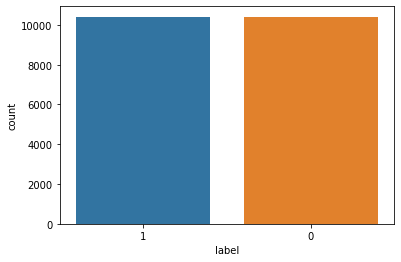

In [12]:
sns.countplot(data=news_dataset,
              x='label',
              order=news_dataset['label'].value_counts().index)

In [13]:
# Merging 'title' and 'author' column in a new column 'body'
news_dataset['body']=news_dataset['author']+' '+news_dataset['title']


In [14]:
print(news_dataset['body'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: body, Length: 20800, dtype: object


**Stemming :**

Returning only the root word by removing its prefix and suffix.

For eg :
teacher,teaching --> teach

In [15]:
port_stem =PorterStemmer()

In [16]:
def stemming(body):
  # replacing all the words(like number , punctuations etc) that do not come in the below defined set (i.e. contains only alphabet ) with a space
  stemmed_body =re.sub('[^a-zA-Z]',' ',body)
  # converting all words to lowercase,as it might happen that our model misinterpret upper letter word to be more significant
  stemmed_body =stemmed_body.lower()
  # splitting into list
  stemmed_body =stemmed_body.split()
  # stem all the words that are not stopwords
  stemmed_body =[port_stem.stem(word) for word in stemmed_body if not word in stopwords.words('english')]
  # join all the stemmed words
  stemmed_body =' '.join(stemmed_body)
  return stemmed_body

In [17]:
# Applying stemming function to our dataset's body column
news_dataset['body']=news_dataset['body'].apply(stemming)

In [18]:
print(news_dataset['body'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: body, Length: 20800, dtype: object


In [19]:
# Seperating the data and label
X =news_dataset['body'].values
Y =news_dataset['label'].values


In [20]:
print(X)
print(Y)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']
[1 0 1 ... 0 1 1]


Let’s visualize the WordCloud for fake and real news separately.

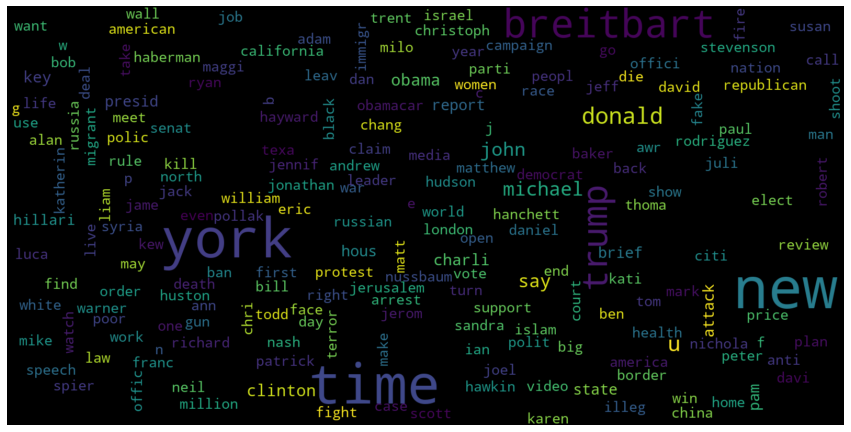

In [21]:
# Real
consolidated = ' '.join(
    word for word in news_dataset['body'][news_dataset['label'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

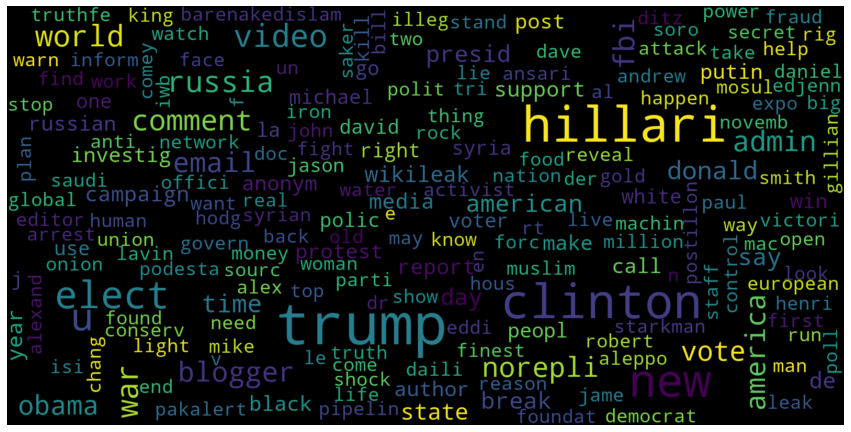

In [22]:
# Fake
consolidated = ' '.join(
    word for word in news_dataset['body'][news_dataset['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

**What is a TfidfVectorizer?**

*TF (Term Frequency):* The number of times a word appears in a document is its Term Frequency. A higher value means a term appears more often than others, and so, the document is a good match when the term is part of the search terms.

*IDF (Inverse Document Frequency):* Words that occur many times a document, but also occur many times in many others, may be irrelevant. IDF is a measure of how significant a term is in the entire corpus.

The TfidfVectorizer converts a collection of raw documents into a matrix of TF-IDF features.

Thus in TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.


In [23]:
# Converting the textual data to numerical data using TfidfVectorizer
vectorizer =TfidfVectorizer()
vectorizer.fit(X) # not doing on Y as it is already a numerical vector
X =vectorizer.transform(X)

In [24]:
# X after numerical vectorization
print(X)


  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

In [25]:
# Splitting the dataset to training and test data
X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)


**Note** : In the above cell

*stratify=Y* will make sure that random split has same proportion of 0 's and 1 's as that in original dataset

*random_state* is used to set the seed for the random generator so that we can ensure that the results that we get can be reproduced.

**Model Training : logistic regression**

In [26]:
model = LogisticRegression()
#training the model
model.fit(X_train,Y_train)

LogisticRegression()

**Evaluation and Prediction**

In [27]:
# Predict training data
Y_train_pred = model.predict(X_train)
# accuracy score of training data
training_accuracy = accuracy_score(Y_train_pred,Y_train)

In [28]:
print('Accuracy score of training data :',training_accuracy)

Accuracy score of training data : 0.9865985576923076


In [29]:
# Predict testing data
Y_test_pred = model.predict(X_test)
# accuracy score of test data
test_accuracy = accuracy_score(Y_test_pred,Y_test)

In [30]:
print('Accuracy score of test data :',test_accuracy)

Accuracy score of test data : 0.9790865384615385


**Model Training : Decision Tree Classifier**

In [31]:
model = DecisionTreeClassifier()
#training the model
model.fit(X_train,Y_train)

DecisionTreeClassifier()

**Evaluation and Prediction**


In [32]:
# Predicting training data
Y_train_pred=model.predict(X_train)
# accuracy score of training data
training_accuracy = accuracy_score(Y_train_pred,Y_train)

In [33]:
print('Accuracy score of training data :',training_accuracy)

Accuracy score of training data : 1.0


In [34]:
# Predict testing data
Y_test_pred = model.predict(X_test)
# accuracy score of test data
test_accuracy = accuracy_score(Y_test_pred,Y_test)

In [35]:
print('Accuracy score of test data :',test_accuracy)

Accuracy score of test data : 0.9925480769230769


The confusion matrix for Decision Tree Classifier can be implemented with the code below.

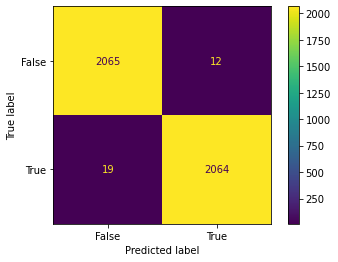

In [36]:
# Confusion matrix of Results from Decision Tree classification
cm = metrics.confusion_matrix(Y_test, model.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

**Making a predictive system**

In [37]:

X_new =X_test[0]
prediction = model.predict(X_new)
print(prediction)
if (prediction[0]==0):
  print("It's a real news")
else :
  print("It's a fake news")

[1]
It's a fake news


In [38]:
# Cross verifying above prediciton
print(Y_test[0])
if (Y_test[0]==0):
  print("It's a real news")
else :
  print("It's a fake news")

1
It's a fake news


**Conclusion**

*Decision Tree Classifier* and *Logistic regression* are performing well.